## Segmentation of Cell Images using FPN and Keras

We will implement a FPN (Feature Pyramid Networks) using Keras for image segmentation. 
Sources:
- Original paper on FPN:  "Feature Pyramid Networks for Object Detection", Lin et al.
- Inspiration from: https://github.com/cxhernandez/cellcount

In [1]:
import keras
import os
import pathlib
import matplotlib
import matplotlib.image
import matplotlib.pyplot
import sklearn.model_selection

Using TensorFlow backend.


In [2]:
ground_truth_dir = os.path.expanduser("~/ML_Segmentation_data/GroundTruth/")
images_dir = os.path.expanduser("~/ML_Segmentation_data/Images/")

In [3]:
img_file_extension = ".TIF"
image_names = os.listdir(ground_truth_dir)
image_names = [x for x in image_names if x.endswith(img_file_extension)]

In [4]:
#List of couples ground truth image - raw image
image_paths = [(ground_truth_dir + im, images_dir + im) for im in image_names]

In [5]:
#Check if all the couples have a corresponding file name and that the shape is the expected one
expected_shape = (520, 696)

def read_img_double(path):
    img = matplotlib.image.imread(path)
    return keras.backend.cast_to_floatx(img)

def check_file(path):
    file_handle = pathlib.Path(path)
    if not file_handle.is_file():
        raise IOError(path + " does not exist!") 
    img = read_img_double(path)
    if img.shape != expected_shape:
        raise IOError(path + " inconsistent shape! It has shape " + str(img.shape))


        
def check_files_exist(couples):
    for a,b in couples:
        check_file(a)
        check_file(b)
    print("All files, both raws and ground truth exist and have correct dimensions")

In [6]:
 check_files_exist(image_paths)

All files, both raws and ground truth exist and have correct dimensions


In [7]:
#Divide train and test set
train_imgs, test_imgs =  sklearn.model_selection.train_test_split(image_paths, test_size = 0.2)

In [8]:
print(len(train_imgs) + len(test_imgs))
print(len(image_paths))
print(len(train_imgs))

1200
1200
960


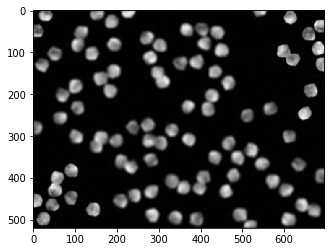

In [9]:
%matplotlib inline
#show raw image
img = read_img_double(train_imgs[0][1])
imgplot = matplotlib.pyplot.imshow(img, cmap = 'gray')

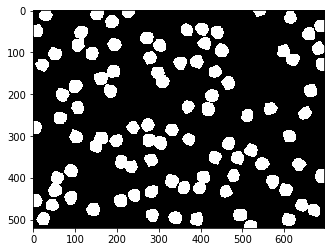

In [10]:
#show ground truth
img=read_img_double(train_imgs[0][0])
imgplot = matplotlib.pyplot.imshow(img, cmap = 'gray')

In [11]:
#the images are float32 matrixes as the keras backend is
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
def create_up_layer(input_layer, kernel_size, downsample):
    activation_function_pyramid = 'relu'
    conv_layer = keras.layers.Conv2D(128, kernel_size, padding='same',
                                     activation = activation_function_pyramid)(input_layer)
    return keras.layers.MaxPooling2D(downsample, padding="valid")(conv_layer)

def create_down_layer(corresponding_layer_in_up_pyramid, previous_layer_down_pyramid, downsample = None):
    if(previous_layer_down_pyramid is None):
        prev_layer = corresponding_layer_in_up_pyramid
    else:
        prev_layer = keras.layers.Add()([corresponding_layer_in_up_pyramid, previous_layer_down_pyramid])
    
    return keras.layers.UpSampling2D(downsample)(prev_layer)

In [13]:
base_up_pyramid = keras.layers.Input(shape = (512, 688, 1))
print (base_up_pyramid)

Tensor("input_1:0", shape=(?, 512, 688, 1), dtype=float32)


In [15]:
downsample = [2, 2]
kernel_size = [3, 3]

up_layer1 = create_up_layer(base_up_pyramid, kernel_size, downsample)
up_layer2 = create_up_layer(up_layer1, kernel_size, downsample)
up_layer3 = create_up_layer(up_layer2, kernel_size, downsample)
up_layer4 = create_up_layer(up_layer3, kernel_size, downsample)

down_layer4 = create_down_layer(up_layer4, None, downsample)
down_layer3 = create_down_layer(up_layer3, down_layer4, downsample)
down_layer2 = create_down_layer(up_layer2, down_layer3, downsample)
down_layer1 = create_down_layer(up_layer1, down_layer2, downsample)
out_layer = keras.layers.Conv2D(1, kernel_size, padding="same")(down_layer1)

model = keras.models.Model(inputs = [base_up_pyramid], outputs = [out_layer])